# Dependencies

Make sure the following packages are installed before starting the lab session:

- numpy
- matplotlib
- scipy

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import multivariate_normal, norm
from mpl_toolkits.mplot3d import Axes3D

# Gaussian Processes
## Introduction

During the course, we have seen various parametric machine learning models. A function is fit, based on a fixed and small amount of parameters. This is a model-driven approach and it makes strong assumptions on the data (i.e. that it can be fit with these parameters).

Now, we will introduce the **Gaussian Process** model which is a non-parametric machine learning algorithm. The number of parameters is flexible and few assumptions are made about the data. The only assumption on the data is that all sub-sets of data points are *jointly Normal distributed*.

To illustrate this joint Normal distribution, let's look at the measurement of the heartbeat of a patient. This measurement can be modelled as a sample drawn from a Gaussian prior $\mathcal{N}(\mu,\sigma^2)$.

Sample = [61.95541696]


Text(0.5, 0, 'heartbeats / min')

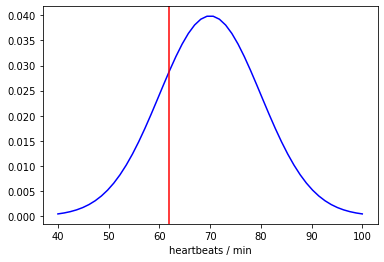

In [2]:
np.random.seed(1000)

# define parameters of the distribution
mu = 70
sigma = 10

# draw a random sample
sample = np.random.normal(mu, sigma, 1)
print('Sample = ' + str(sample))

# plot the sample and the distribution
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 50)
plt.plot(x,norm.pdf(x,mu,sigma),'b')
plt.axvline(x = sample,color='r')
plt.xlabel('heartbeats / min')

The heartbeat of a patient is constantly changing, so of course we can take multiple measurements. If we take an additional sample, we can model the two samples as being drawn form a bi-variate Gaussian distribution $\mathcal{N}(\mu,\Sigma)$ in which $\Sigma$ represents the covariance matrix.

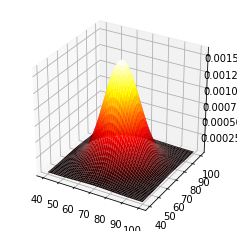

In [3]:
# define parameters of the distribution
mu = np.array([70,70])
cov = np.array([[sigma**2, 0],
                [0,        sigma**2]])

# plot the joint distribution
X, Y = np.meshgrid(np.linspace(40,100,500),np.linspace(40,100,500))
grid_points = np.empty((500,500,2))
grid_points[:, :, 0] = X; 
grid_points[:, :, 1] = Y

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, multivariate_normal(mu, cov).pdf(grid_points),cmap='hot',linewidth=0)

If N samples are drawn, this can be modelled as a sample drawn from an N-variate Gaussian distribution. We can keep on drawing as much samples as we want up to infinity, leading to an infinite number of random variables. This is a Gaussian process: a collection of *random variables*, any finite number of which have a *joint Gaussian distribution*. (slide 9, 17)

## Specifying a Gaussian process

A Gaussian process can be seen as a Gaussian distribution over functions: some restrictions are put in place, indicating how the variables are linked. A Gaussian process is fully specified by (slide 16):

- mean function m(x), often assumed to be zero
- covariance function k(x1,x2), the kernel function

The kernel function is used to determine how different observations inform one another. In our case of the heartrate, this means that samples that are close together in time will likely result in a similar heartrate as it cannot drastically change from one measurement to the next.

A typical example of a kernel is the Squared Exponential kernel function (slide 25-30):

$k(x_p,x_q) = \sigma^2 \exp(-\frac{1}{2l^2}(x_p-x_q)^2)$


This kernel function has two hyperparameters:

- $\sigma$ = signal variance
- $l$ = length scale

We will now implement this Squared Exponential kernel function. The first two arguments of the function are X1 and X2 which are respectively an MxD and NxD matrix of D-dimensional data points for which the similarity in kernel space has to be computed. The result is an MxN matrix with the kernel value for each X1[m,:]-X2[n,:] combination. The other arguments of the function are the kernel hyperparameters.

Some useful tips to understand the implementation:
- $||P-Q|| = \sqrt{||P||^2 + ||Q||^2 - 2P.Q}$
- with broadcasting, the implementation can be very efficient

In [4]:
def squared_exponential_kernel(X1, X2, l = 1.0, sigma_f = 1.0):
    squared_distance = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    kernel_result = sigma_f**2 * np.exp(-0.5/l**2 * squared_distance)
    return kernel_result

By defining the kernel function, a prior is put on the Gaussian process. It is now possible to draw samples from this prior. Every sample that is drawn represents a possible function.

To draw samples for the GP prior, we use the algorithm as described on slide 43:

- Choose a number of input points $X_*$
- Evaluate the covariance matrix K($X_*$,$X_*$)
- Draw a random Gaussian vector from $y_* \sim \mathcal{N}(0,K)$
- Plot the values of $y_*$ versus $X_*$

Text(0, 0.5, 'hearbeats / min')

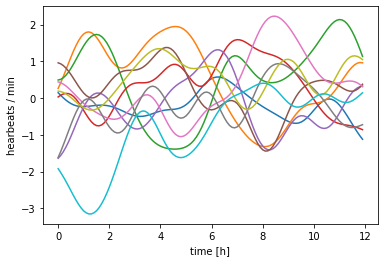

In [5]:
# generate a range of inputs at which to evaluate the function
X_star = np.arange(0, 12, 0.1).reshape(-1, 1)

# determine parameters of prior
mu = np.zeros(X_star.shape)
cov = squared_exponential_kernel(X_star, X_star)

# draw 10 samples from the prior
y_star = np.random.multivariate_normal(mu.ravel(), cov, 10)

# plot the samples
for i in range(10):
    plt.plot(X_star[:],y_star[i,:])
plt.xlabel('time [h]')
plt.ylabel('hearbeats / min')

Each of the samples represents one of the possible functions to be drawn from the Gaussian process. In our case, each line represents a possible heartbeat pattern given the current prior information.


In [6]:
########################### READ ONLY ###########################

To continue building our model, we need to make some observations of the data. These observations can then be used as anchor points of the Gaussian process.

We now define a heartbeat function:

Text(0, 0.5, 'heartbeats / min')

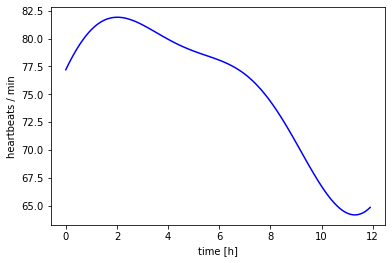

In [7]:
def heartbeat(time):
    return 10* np.sin(0.5 * time + 6) + 5 * np.cos(0.75 * time) + 75

plt.plot(X_star,heartbeat(X_star),'b')
plt.xlabel('time [h]')
plt.ylabel('heartbeats / min')

The above graph shows how the average rate of the heartbeats varies across 12 hours. We will now make some observations from this data for training our Gaussian process model:

Text(0, 0.5, 'heartbeats / min')

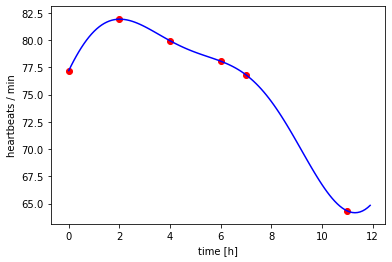

In [8]:
# make observations at these locations, DO NOT change this
X_train = np.array([0,2,4,6,7,11]).reshape(-1, 1)

# make the observations
y_train = heartbeat(X_train)

# plot the observations
plt.plot(X_star,heartbeat(X_star),'b')
plt.scatter(X_train,y_train,c='r')
plt.xlabel('time [h]')
plt.ylabel('heartbeats / min')

The above observations can be used to train the Gaussian process model. We now define a new function *posterior* which computes the posterior $\mu$ and $\Sigma$ of our model, evaluated at locations $X_*$ after observing $X_{\text{train}}$ and $y_{\text{train}}$.

The function has the following parameters:

- $X_*$, the locations at which to evaluate the posterior
- $X_{\text{train}}$ and $y_{\text{train}}$, the training data
- *kernel_fnc*, a general kernel function
- *kernel_parameters*, a dictionary of all the hyperparameters of the specified kernel
- $\sigma_n$, the kernel noise hyperparameter

We define the following:

- $K = K(X_{\text{train}},X_{\text{train}})$
- $K_* = K(X_{\text{train}},X_*)$
- $K_{**} = K(X_*,X_*)$

Then, using the algorithm on slide 76, we can write:

- $\mu_* = K_*^T(K + \sigma_n^2I)^{-1}y_{\text{train}}$
- $\Sigma_* = K_{**} - K_*^T(K + \sigma_n^2I)^{-1}K_*^T$

To efficiently compute the inverse, we use the Cholesky decomposition $L$ of any matrix $A$ as follows:

$A^{-1} = (L^{-1})^T(L^{-1})$

This can be computed in Python using the np.linalg.cholesky function. The best performance is when using the $L$ matrix to solve a system of linear equations instead of computing the inverse. When solving the system $AX=B$ for $X$, we actually solve $X=A^{-1}B$. For clarity purposes, we will just use the inverse of the $L$ matrix.

In [9]:
def posterior(X_star, X_train, y_train, kernel_fnc, kernel_parameters = {}, sigma_n = 1e-5):
    
    K = kernel_fnc(X_train,X_train,**kernel_parameters)
    K_star = kernel_fnc(X_train,X_star,**kernel_parameters)
    K_star_star = kernel_fnc(X_star,X_star,**kernel_parameters)
    
    L = np.linalg.cholesky(K + sigma_n**2 * np.eye(K.shape[0]))
    L_inv = np.linalg.inv(L)
    
    mu_star = np.dot(np.dot(K_star.T,L_inv.T),np.dot(L_inv,y_train)).reshape((X_star.shape[0],))
    cov_star = K_star_star - np.dot(np.dot(K_star.T,L_inv.T),np.dot(L_inv,K_star))
    
    return mu_star, cov_star

Now we can compute the posterior distribution at test points $X_*$ and use this to draw new samples from our posterior.

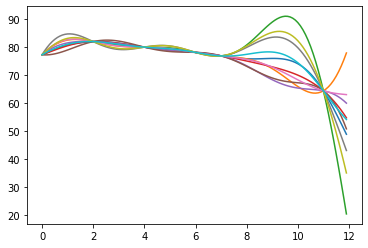

In [10]:
mu_star, cov_star = posterior(X_star,
                              X_train,
                              y_train,
                              squared_exponential_kernel,
                              {'l':3.0,'sigma_f':100.0})

# draw 10 samples from the posterior
y_star = np.random.multivariate_normal(mu_star.ravel(), cov_star, 10)
for i in range(10):
    plt.plot(X_star[:],y_star[i,:])

This lead to a very interesting plot. The lines show several samples of possible functions in the GP model. To visualise this further, we can use a typical visualisation method of Gaussian processes by showing the mean prediction and the 95% confidence interval.

In [11]:
# This function generates a plot of the Gaussian process, evaluated at X_star
# if num_samples > 0, random samples are drawn from the posterior distribution and plotted as well
def GPplot(X_star,X_train,y_train,mu_star,cov_star, num_samples = 0, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # plot training data
    ax.plot(X_train,y_train,'rs',label=u'f(x)')
    
    # plot posterior mean
    ax.plot(X_star,mu_star,label=u'$\mu$')
    
    # plot confidence interval
    stdv = np.sqrt(np.diag(cov_star))
    ax.fill_between(X_star.flat, mu_star-2*stdv, mu_star+2*stdv, color="#DEF9FF",label='95% CI')
    
    for i in range(num_samples):
        ax.plot(X_star[:], np.random.multivariate_normal(mu_star.ravel(), cov_star, 1)[0,:],'--',label='posterior sample')
    
    # legend
    ax.legend(loc='best', framealpha=0.5)

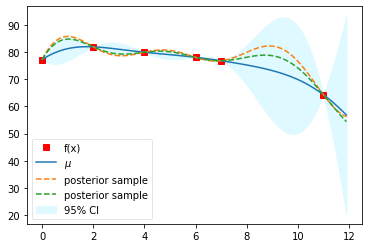

In [12]:
GPplot(X_star,X_train,y_train,mu_star,cov_star,num_samples=2)

## Hyperparameters

As mentioned earlier, the kernel function has several hyperparamters. In the above example, we fixed the hyperparameters to a certain value. Now we will generate plots for several combinations of hyperparameters to analyse their influence. (slide 78-88)

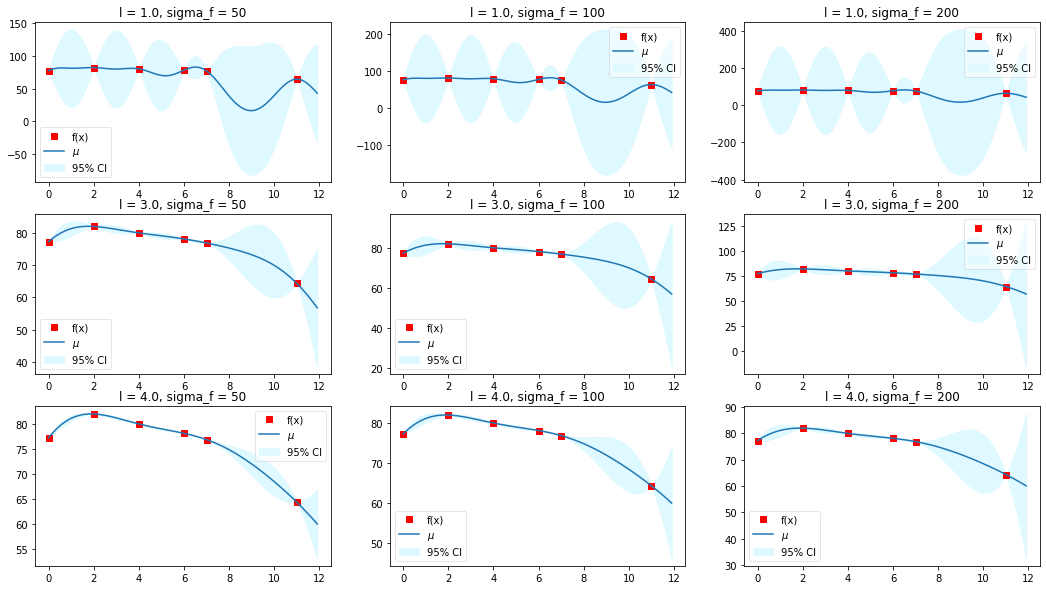

In [13]:
# range of the hyperparameters
lengthscale = [1.0,3.0,4.0]
signal_variance = [50,100,200]

# create figure
f,axes = plt.subplots(len(lengthscale),len(signal_variance),figsize=(18, 10))

# plot each combination
for l_i, l in enumerate(lengthscale):
    for sigma_f_i, sigma_f  in enumerate(signal_variance):
        # compute the posterior distribution at X_star for each combination
        mu_star, cov_star = posterior(X_star,
                                      X_train, 
                                      y_train,
                                      squared_exponential_kernel, 
                                      {'l':l, 'sigma_f': sigma_f})
        # plot the GP
        GPplot(X_star,X_train,y_train,mu_star,cov_star,ax=axes[l_i,sigma_f_i])
        axes[l_i,sigma_f_i].set_title('l = ' + str(l) + ', sigma_f = ' + str(sigma_f))

In [14]:
########################### READ ONLY ###########################

The hyperparameters can have a large influence on the model. Luckily, we can infer the parameter values form the data. (slide 73-75)

To do this, we optimize the Marginal Likelihood (log-likelihood):

$\log p(y_{\text{train}}|X_{\text{train}}) = - \frac{1}{2}y_{\text{train}}^T(K + \sigma_n^2I)^{-1}y_{\text{train}} - \frac{1}{2} \log |K + \sigma_n^2I| - \frac{N}{2} \log (2\pi)$

This log-likelihood needs to be maximized. As we will use the SciPy minimize function, we will minimize the negative-log-likelihood. The SciPy minimize function, minimizes a function $f(X)$ in which $X$ is a vector of parameters of the function. We will define a get_NegativeLogLikelihood function which generates a function $NegativeLogLikelihood(X)$ that computes the NLL for a specific combination of hyperparameters $X$.

Tip: |A| = sum(diag(L)), where L is the Cholesky decomposition of A.

In [15]:
def get_NegativeLogLikelihood(X_train,y_train, kernel_fnc, kernel_parameter_names):
    
    # define a function that only takes the hyperparameters as argument
    def NegativeLogLikelihood(parameters):
        
        kernel_parameters = {kernel_parameter_names[i]:parameters[i] for i in range(len(parameters))}
        
        sigma_n = kernel_parameters.pop('sigma_n', None)
        if sigma_n is None:
            sigma_n = 1e-5
            
        K = kernel_fnc(X_train,X_train,**kernel_parameters)
        
        L = np.linalg.cholesky(K + sigma_n**2 * np.eye(K.shape[0]))
        L_inv = np.linalg.inv(L)
        
        N = len(X_train)
        negativeLogLikelihood =  np.sum(0.5 * np.dot(np.dot(y_train.T,L_inv.T),np.dot(L_inv,y_train)) + 
                      np.log(np.diag(L)) + 
                      0.5 * N * np.log(2*np.pi))

        return negativeLogLikelihood
    
    # return the function
    return NegativeLogLikelihood

For the optimization procedure, we will use the SciPy minimize function. Note that the optimisation would be much better if we computed the gradients of the negative-log-likelihood. However, for this demo, we do not use it. By doing so, you can later on do somes tests with the code yourself without having to reimplement this, e.g. try different kernel functions for different data sets.

In [16]:
NLL = get_NegativeLogLikelihood(X_train, 
                                y_train,
                                squared_exponential_kernel,
                                ['l','sigma_f'])

optimisation_result = minimize(NLL, 
                               [1, 1], 
                               bounds=((1e-5, None), (1e-5, None)),
                               method='L-BFGS-B')

l_opt, sigma_f_opt = optimisation_result.x

print('Hyperparameter optimisation finished')
print('l_opt = ' + str(l_opt))
print('sigma_f_opt = ' + str(sigma_f_opt))

Hyperparameter optimisation finished
l_opt = 5.019327584908929
sigma_f_opt = 128.65095084323514


The optimisation procedure resulted in a new set of hyperparameters. Let's plot the new GP with optimized hyperparameters.

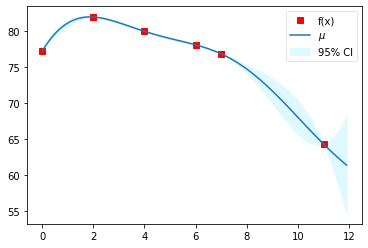

In [17]:
mu_star, cov_star = posterior(X_star,
                              X_train,
                              y_train,
                              squared_exponential_kernel,
                              {'l':l_opt, 'sigma_f': sigma_f_opt})

GPplot(X_star,X_train,y_train,mu_star,cov_star)

## Noisy observations

In the heartbeat example above, we implicitly assumed that all measurements were correct. In reality however, there is often some error on measurement. In following experiment, we will introduce some noise to the measurements and tell the Gaussian process optimisation method that there is a noise parameter to be optimised. (slide 57-62)

In [18]:
# this defines the amount of noise
sigma = 2

X_train = np.array([0,2,4,6,7,11]).reshape(-1, 1)
y_train = heartbeat(X_train) + np.random.normal(0,sigma,len(X_train)).reshape((-1,1))

Let's get the optimal hyperparameters and plot the GP

In [19]:
NLL = get_NegativeLogLikelihood(X_train, 
                                y_train,
                                squared_exponential_kernel,
                                ['l','sigma_f','sigma_n'])

optimisation_result = minimize(NLL, 
                               [1, 1, 1], 
                               bounds=((1e-5, None), (1e-5, None), (1e-5, None)),
                               method='L-BFGS-B')

l_opt, sigma_f_opt, sigma_n_opt = optimisation_result.x

print('Hyperparameter optimisation finished')
print('l_opt = ' + str(l_opt))
print('sigma_f_opt = ' + str(sigma_f_opt))
print('sigma_n_opt = ' + str(sigma_n_opt))

Hyperparameter optimisation finished
l_opt = 15.463602698355537
sigma_f_opt = 128.21074036815617
sigma_n_opt = 4.503953880203399


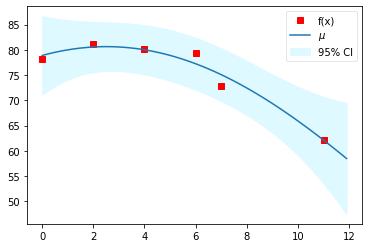

In [20]:
mu_star, cov_star = posterior(X_star,
                              X_train,
                              y_train,
                              squared_exponential_kernel,
                              {'l':l_opt, 'sigma_f': sigma_f_opt},
                              sigma_n = sigma_n_opt)

GPplot(X_star,X_train,y_train,mu_star,cov_star)

## Gaussian Process-based optimisation

Gaussian processes can also be used for finding the optimum of a target function as seen on slide 101. This method of optimisation is typically applied in cases when gathering an extra sample is expensive (e.g. due to computational requirements, time constraints, ...).

Gaussian process-based optimisation is a form of surrogate-based optimisation and Bayesian optimisation. To use this method, we will follow the algorithm that is demonstrated on slide 103:

- Gather data $f(X)$ at points $X$
- Approximate $f(X)$ using a GP
- Minimize a loss function and iteratively add data

First, we will define a function to be minimized. For this we will use the Forrester function, which is a typical example of 1-dimensional optimisation problem.

In [21]:
def forrester(x):
    return (6*x - 2)**2 * np.sin(12*x - 4)

In [22]:
# Define a range where we want to evaluate the GP
X_star = np.arange(0, 1, 0.01).reshape(-1, 1)

# Gather some samples f(X) at points X for training the GP
X_train = np.array([0.1,0.5,0.9]).reshape(-1, 1)
y_train = forrester(X_train)

Let's use this training data to build and optimise a Gaussian process. We also plot the original target function to see how good the approximation of the GP is. Note that in reality, we do not know this target function. We only have the training data.

Hyperparameter optimisation finished
l_opt = 0.34967744245113563
sigma_f_opt = 6.2100998191121475


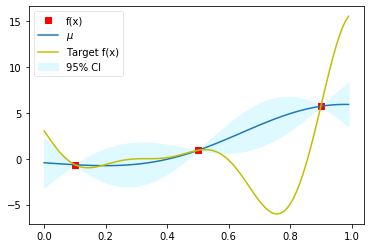

In [23]:
NLL = get_NegativeLogLikelihood(X_train, 
                                y_train,
                                squared_exponential_kernel,
                                ['l','sigma_f'])

optimisation_result = minimize(NLL, 
                               [0.1, 1], 
                               bounds=((1e-5, None), (1e-5, None)),
                               method='L-BFGS-B')

l_opt, sigma_f_opt = optimisation_result.x

print('Hyperparameter optimisation finished')
print('l_opt = ' + str(l_opt))
print('sigma_f_opt = ' + str(sigma_f_opt))

mu_star, cov_star = posterior(X_star,
                              X_train,
                              y_train,
                              squared_exponential_kernel,
                              {'l':l_opt,'sigma_f':sigma_f_opt})
GPplot(X_star,X_train,y_train,mu_star,cov_star)

plt.plot(X_star,forrester(X_star),'y',label = 'Target f(x)')
ax = plt.gca()
ax.legend(loc='best', framealpha=0.5)

After collecting some data points, we have build our GP model. How can we use this GP to find the optimum of our target function? A simple method could be by just evaluating the GP at it's minimum. The reasoning behind this is that the currently collected data points will probably give some indication of the position of the real minimum.

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


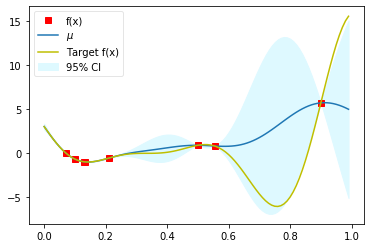

In [24]:
# take num_iter extra samples
num_iter = 5

i = 0

np.random.seed(1000)

# loop over the procudure of gathering extra samples
while i < num_iter:
    print('Iteration: ' + str(i))
    
    # generate 10 random candidate points. In reality, we could pick even more or solve this analytically
    X_candidate = np.random.uniform(0, 1, 10).reshape(-1, 1)
    
    # compute the posterior distribution at these candidate points 
    # for the GP with given training data and previously optimised hyperparameters.
    mu_star, cov_star = posterior(X_candidate,
                                  X_train,
                                  y_train,
                                  squared_exponential_kernel,
                                  {'l':l_opt,'sigma_f':sigma_f_opt})
    
    # compute the location of the minimum in the candidate points. We will use the minimum of the mean of the GP
    minimum_loc = np.argmin(mu_star)
    
    # gather this extra data point and extend the dataset
    X_train = np.concatenate((X_train,X_candidate[minimum_loc,:].reshape((-1,1))))
    y_eval = forrester(X_candidate[minimum_loc,:]).reshape((-1,1))
    y_train = np.concatenate((y_train,y_eval))
    
    # compute the NLL function so that we can optimise our GP model with this new data
    NLL = get_NegativeLogLikelihood(X_train, 
                                    y_train,
                                    squared_exponential_kernel,
                                    ['l','sigma_f'])

    # perform the optimisation procedure
    optimisation_result = minimize(NLL, 
                                   [0.1, 1], 
                                   bounds=((1e-5, None), (1e-5, None)),
                                   method='L-BFGS-B')

    # get the optimimum to be used in the next iteration or the visualisation at the end
    l_opt, sigma_f_opt = optimisation_result.x

    # go to the next iteration
    i += 1
    
# compute the posterior distribution at X_star for visualisation purposes
mu_star, cov_star = posterior(X_star,
                              X_train,
                              y_train,
                              squared_exponential_kernel,
                              {'l':l_opt,'sigma_f':sigma_f_opt})

# plot the GP with the full set of data that has been gathered
GPplot(X_star,X_train,y_train,mu_star,cov_star)

# also plot the target function
plt.plot(X_star,forrester(X_star),'y',label = 'Target f(x)')
ax = plt.gca()
ax.legend(loc='best', framealpha=0.5)

Take some time to interpret the above figure. Sampling at the mean location does not always lead to the optimum. A better way of gathering samples is by using a more complex loss function, also known as an infill criterion or acquisition function.

Slide 109 provides us with an overview of some possible acquisition functions. The most commonly used are:

**Probability of Improvement (PoI):**

$P(y_* \leq f_{min}) = \int_{-\infty}^{f_{min}} \Phi(y|\mu_*,\Sigma_*)dy$

**Expected Improvement (EI):**

$\mathop{\mathbb{E}}[I] = (f_{min}-\mu_*)\Phi(f_{min})|\mu_*,\Sigma_*) + \Sigma_*\phi(f_{min}|\mu_*,\Sigma_*)$

In these equations, $\Phi$ represents the Cumulative Density Function and $\phi$ represents the Probability Density Function.

Let's implement the Expected Improvement criterion.

In [25]:
def compute_EI(mu_star,cov_star,y_train):
    min_y = np.min(y_train)
    s = np.sqrt(np.diag(cov_star))
    
    z = (min_y - mu_star) / s

    cdf = norm.cdf(z)
    pdf = norm.pdf(z)
    
    return (min_y - mu_star) * cdf + s * pdf

We will now plot the EI criterion for our initial set of samples.

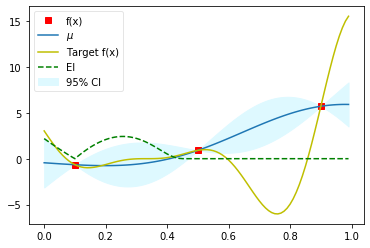

In [26]:
# Gather some samples f(X) at points X for training the GP
X_train = np.array([0.1,0.5,0.9]).reshape(-1, 1)
y_train = forrester(X_train)

NLL = get_NegativeLogLikelihood(X_train, 
                                y_train,
                                squared_exponential_kernel,
                                ['l','sigma_f'])

optimisation_result = minimize(NLL, 
                               [0.1, 1], 
                               bounds=((1e-5, None), (1e-5, None)),
                               method='L-BFGS-B')

l_opt, sigma_f_opt = optimisation_result.x

mu_star, cov_star = posterior(X_star,
                              X_train,
                              y_train,
                              squared_exponential_kernel,
                              {'l':l_opt,'sigma_f':sigma_f_opt})

EI = compute_EI(mu_star,cov_star,y_train)

GPplot(X_star,X_train,y_train,mu_star,cov_star)

plt.plot(X_star,forrester(X_star),'y',label = 'Target f(x)')
plt.plot(X_star,5*EI,'g--', label = 'EI')
ax = plt.gca()
ax.legend(loc='best', framealpha=0.5)

Now let's run some iterations of the algorithm using the Expected Improvement criterion (slide 98).

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


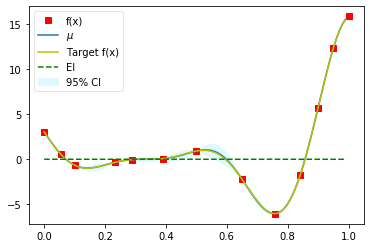

In [27]:
num_iter = 10

i = 0

X_train = np.array([0.1,0.5,0.9]).reshape(-1, 1)
y_train = forrester(X_train)

np.random.seed(1000)

while i < num_iter:
    print('Iteration: ' + str(i))
    
    def eval_EI(X_candidate):
        X_candidate = X_candidate.reshape(-1,1)
        mu_star, cov_star = posterior(X_candidate,
                                      X_train,
                                      y_train,
                                      squared_exponential_kernel,
                                      {'l':l_opt,'sigma_f':sigma_f_opt})
        EI = compute_EI(mu_star,cov_star,y_train)
        return -1.0*EI

    # The expected improvement itself also needs to be optimized!
    EI_optimisation_result = minimize(eval_EI,
                                      [np.random.uniform(0, 1, 1).reshape(-1, 1)],
                                      bounds=[(0,1)],
                                      method='L-BFGS-B')
    
    X_candidate = EI_optimisation_result.x
    
    X_train = np.concatenate((X_train,X_candidate.reshape((-1,1))))
    y_eval = forrester(X_candidate).reshape((-1,1))
    y_train = np.concatenate((y_train,y_eval))
    
    NLL = get_NegativeLogLikelihood(X_train, 
                                    y_train,
                                    squared_exponential_kernel,
                                    ['l','sigma_f'])

    optimisation_result = minimize(NLL, 
                                   [0.1, 1], 
                                   bounds=((1e-5, None), (1e-5, None)),
                                   method='L-BFGS-B')

    l_opt, sigma_f_opt = optimisation_result.x
    
    i += 1
    
mu_star, cov_star = posterior(X_star,
                              X_train,
                              y_train,
                              squared_exponential_kernel,
                              {'l':l_opt,'sigma_f':sigma_f_opt})

EI = compute_EI(mu_star,cov_star,y_train)

GPplot(X_star,X_train,y_train,mu_star,cov_star)

plt.plot(X_star,forrester(X_star),'y',label = 'Target f(x)')
plt.plot(X_star,5*EI,'g--', label = 'EI')
ax = plt.gca()
ax.legend(loc='best', framealpha=0.5)